The flux calculated in this notebook is the time-dependent one described in equations from (1) to (5) of [SN1987A neutrino burst: limits on flavor conversion
](https://arxiv.org/abs/2301.11407) paper:

\begin{equation}
        \phi^0_{a, \bar{\nu}_{e}}(E_\nu,t) =\frac{8 \pi c}{(hc)^3} \left [ N_n(t) \sigma_{e^{+}n}(E_\nu) g_{e^+} (E_{e+},T_a) \right ] \nonumber
\end{equation}

\begin{equation}
\begin{split}
     &N(t)=\frac{Y_n}{m_n}\times M_a \times \frac{j_k(t)}{1+t/0.5s} \nonumber \\
     &g_{e^+} (E_{e+},T_a)=\frac{E_{e+}^2}{1+exp\left[E_{e+}/T_a\right]}
\end{split}
\end{equation}

 \begin{equation}
    \phi^0_{c}(E,t) = \frac{\pi c}{(hc)^3} 4\pi R_c^2 \frac{E^2}{1 + \exp[E/T_c(t)]} \nonumber
\end{equation}

\begin{equation}
    T_c(t) = T_c \exp\left[ - t/\left ( 4\tau_c \right) \right] \nonumber
\end{equation}

\begin{equation}
    \phi^{0}_{\bar{\nu}} (t)=  \phi^0_{a}(t)+ (1-j_k(t))\phi^0_{c}(t-\tau_a) \nonumber
\end{equation}

$$j_k(t)=exp\left [ - \left ( t/\tau_a \right)^k \right]$$

This flux corresponds to results from Figures 1 to 4, and also 7 and 8 of that paper.

In [30]:
import math
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [31]:
c = 1
h = 2*np.pi
D=50 #kpc
D = D * 100 * 3.086e19 # kpc to cm
Msun = 1.98848e30 * 1/(1.79e-30) # Sun Mass in MeV
Yn = 0.6	#Neutron fraction in the accreating material
mn = 939.565 #Neutron mass in MeV
erg_to_MeV=6.2415*10**5

#PMNS
#Mixing angles
s12 = np.sqrt(0.307)
c12 = np.cos(np.arcsin(s12))
s23 = np.sqrt(0.545) #Normal order 
c23 = np.cos(np.arcsin(s23))
s13 = np.sqrt(2.18e-2)
c13 = np.cos(np.arcsin(s13))

#PMNS matrix
# Assumindo CP zero e neutrinos de Dirac
U23 = np.array([ [1,0,0],[0,c23,s23],[0,-s23,c23] ])
U13 = np.array([ [c13,0,s13],[0,1,0],[-s13,0,c13] ])
U12 = np.array([ [c12,s12,0],[-s12,c12,0],[0,0,1] ])
U = U23 @ U13 @ U12

######### Cooling #######################
def Tc(t, Tc0, tau_c):
  try:
    T = Tc0 * np.exp(-t/(4*tau_c))
  except RuntimeWarning:
    T = 10**(-20)
    print('Overflow in Tc function')
  return T
    
def ge_antnue(t, Enu, Tc0, tau_c):
    try:
        ge = Enu**2/(1 + np.exp(Enu/Tc(t, Tc0, tau_c)))
    except RuntimeWarning:
        print('Overflow in ge_antnue function, with Tc=',Tc(t, Tc0, tau_c))
        if type(Enu) == np.ndarray or type(Enu) == list:
            ge = np.zeros(len(Enu))
        else:
            ge = 0
    return ge
  
#cooling flux electron antineutrino
#Initially in MeV^2. Converting:
conv = (1e6 * 5.068e4)**2 * 1.519e15 # MeV^2 to 1/(cm² s eV)
def col_flux(t, Enu, Tc0,tau_c, Rc):
    Rc = Rc * 1000 * 100 #km to cm
    flux = 1/(4*math.pi*D**2) * math.pi*c/(h*c)**3 * 4*math.pi * Rc**2 * ge_antnue(t, Enu, Tc0, tau_c) * conv # 1/(cm² s eV)
    return flux
  
 ######## Accretion ##############
def Ta(t, Ta0, Tc0, tau_a):
	Ti = Ta0
	Tf = 0.6*Tc0
	parm_m = 2
	Ta_t = Ti + np.sqrt((Tf - Ti)**2) * (t/tau_a)**parm_m
	return Ta_t
  
#time dependent function to guarantee continuity
#adm
def jk(t, tau_a):
    k_model = 2
    jk = np.exp(-(t/tau_a)**k_model)
    return jk

#neutron distribution function
#adm
def Nn(t, Ta0, Tc0, Ma, tau_a):
    Yn = 0.6
    mn = 939.565 #MeV
    Ma_Msun = Ma*Msun #Msun
    # Nn = Yn/mn * Ma_Msun * (Ta0/Ta(t, Ta0, Tc0, tau_a))**6 * jk(t, tau_a)/(1. + t/0.5) #with Ta(t)
    Nn = Yn/mn * Ma_Msun * jk(t, tau_a)/(1. + t/0.5) #with Ta cte
    return Nn

def Nn_2(t, Ta0, Tc0, Ma, tau_a):
    Yn = 0.6
    mn = 939.565 #MeV
    Ma_Msun = Ma*Msun #Msun
    Nn = Yn/mn * Ma_Msun * (Ta0/Ta(t, Ta0, Tc0, tau_a))**6 * jk(t, tau_a)/(1. + t/0.5) #with Ta(t)
    return Nn

#positron-neutron cross section
#cm^2
def cross_e_n(Enu):
  sigma_cm = 4.8e-44 * Enu**2 / (1 + Enu/260) #cm^2
  return sigma_cm

#positron energy
#MeV
def Epos_vec(Enu):
    Enu=np.array(Enu)
    Epos = np.where(Enu < 1.293, 0., (Enu - 1.293)/(1 - Enu/mn))
    return Epos

#positron spectrum
#MeV^2
def ge(t, Enu,Ta0, Tc0, tau_a):
  try:
    ge = Epos_vec(Enu)**2/(1 + np.exp(Epos_vec(Enu)/Ta0))
  except RuntimeWarning:
    ge = 0
  return ge

def ge_2(t, Enu,Ta0, Tc0, tau_a):
    try:
        ge = Epos_vec(Enu)**2/(1 + np.exp(Epos_vec(Enu)/Ta(t, Ta0, Tc0, tau_a))) #with Ta(t)
    except RuntimeWarning:
        ge = 0
    return ge
  
#accretion flux
#Initially in MeV^2. Converting:
conv = (1e6 * 5.068e4)**2 * 1.519e15 # MeV^2 to 1/(cm² s eV)
def acc_flux(t, Enu, Ta0, Tc0, tau_a, Ma):
    flux = (8*math.pi*c)/(4*math.pi*D**2 * h**3 * c**3) *  Nn(t, Ta0, Tc0, Ma, tau_a) * cross_e_n(Enu) * ge(t, Enu, Ta0, Tc0, tau_a) * conv # 1/(cm² s eV)
    return flux

def acc_flux_2(t, Enu, Ta0, Tc0, tau_a, Ma):
    flux = (8*math.pi*c)/(4*math.pi*D**2 * h**3 * c**3) *  Nn_2(t, Ta0, Tc0, Ma, tau_a) * cross_e_n(Enu) * ge_2(t, Enu, Ta0, Tc0, tau_a) * conv # 1/(cm² s eV)
    return flux

#Garching fluence (time integrated flux)
def phi_Garching(E,E_0,L,alpha): 
    # E[MeV], E_0[MeV], L[10⁵²ergs], alpha
    L=L*(10**52)*erg_to_MeV
    N=((alpha+1)**(alpha+1))/(E_0*gamma(alpha+1))
    R=(L/E_0)*N*((E/E_0)**alpha)*np.exp((-1)*(alpha+1)*E/E_0)/(4*math.pi*D**2)
    return R #MeV⁻¹.cm⁻²

#Sigmoid function for the Spectral Split analysis
def sig(x,x_0=0,lamb=1):
  return 1/(1 + np.exp(-(x-x_0)/lamb))

In [32]:
def antinu_e_flux(t,Enu,Tc0,tau_c,Rc,tau,Ta0,tau_a,Ma,Pee,mass_ord="NH",acc="no"):
  #Antinu_e and Antinu_x initial fluxes
  #Antinu_x flux: only cooling with T_c0=tau*Tc0
  if acc=="yes":
    antinu_e_flux_0=acc_flux(t, Enu,Ta0, Tc0, tau_a, Ma) + (1 - jk(t, tau_a)) * col_flux(t - tau_a, Enu, Tc0, tau_c, Rc)
    antinu_x_flux_0=(1 - jk(t, tau_a)) * col_flux(t - tau_a, Enu, tau*Tc0, tau_c, Rc)  
  elif acc=="yes2":
    antinu_e_flux_0=acc_flux_2(t, Enu,Ta0, Tc0, tau_a, Ma) + (1 - jk(t, tau_a)) * col_flux(t - tau_a, Enu, Tc0, tau_c, Rc)
    antinu_x_flux_0=(1 - jk(t, tau_a)) * col_flux(t - tau_a, Enu, tau*Tc0, tau_c, Rc)
  elif acc=="yes_contemporaneous":
    antinu_e_flux_0=acc_flux(t, Enu,Ta0, Tc0, tau_a, Ma) + col_flux(t, Enu, Tc0, tau_c, Rc)
    antinu_x_flux_0=col_flux(t, Enu, tau*Tc0, tau_c, Rc)  
  elif acc=="no":
      antinu_e_flux_0=col_flux(t, Enu, Tc0, tau_c, Rc)
      antinu_x_flux_0=col_flux(t, Enu, tau*Tc0, tau_c, Rc)
  else:
    print('Invalid!')
    return 0
  
  #Flavor Conversion Mechanisms
  if mass_ord=="NH":
    Pee_aux= U[0][0]**2 #U^2_e1
  elif mass_ord=="IH":
    Pf=0
    Pee_aux= (U[0][2]**2)*(1-Pf)+ (U[0][0]**2)*Pf #U^2_e3 * (1-Pf) + U^2_e1 * Pf
  elif mass_ord=="no":
    Pee_aux= Pee
      
  elif mass_ord=="E_swap":
      Pee_aux_nubar=0
      E_swap=Pee
      Pee_aux=1-sig(Enu,E_swap,0.1)
        
  elif mass_ord=="E_swap_inv":
      Pee_aux_nubar=0
      E_swap=Pee
      Pee_aux=sig(Enu,E_swap,0.1)
        
  else:
    print('Invalid!')
    return 0

  antinu_e_flux= antinu_e_flux_0*Pee_aux+(1-Pee_aux)*antinu_x_flux_0
  return antinu_e_flux #MeV⁻¹.s⁻¹.cm⁻²

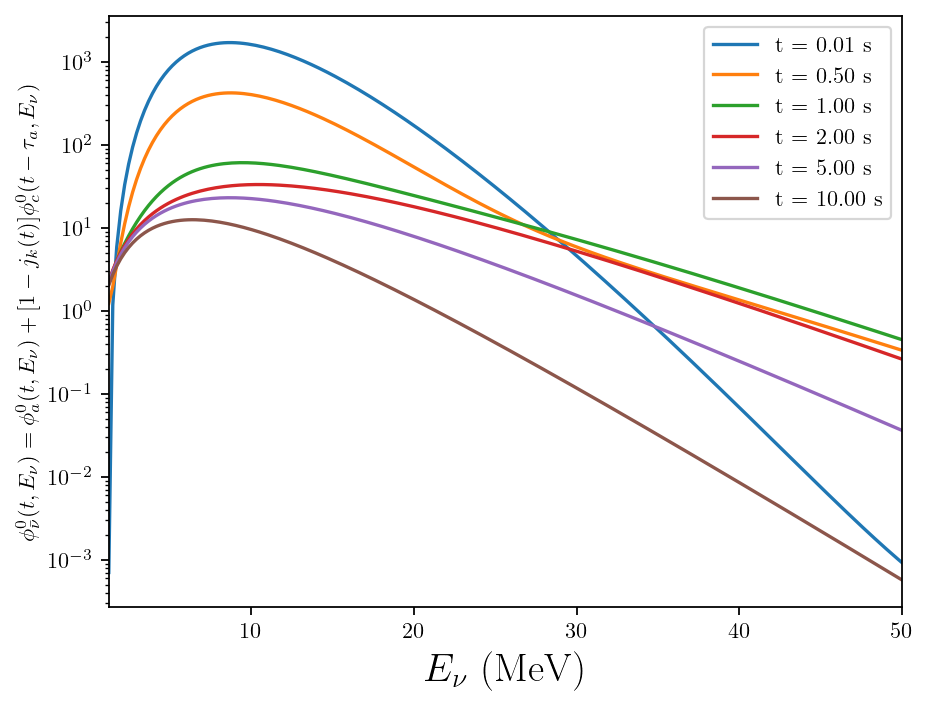

In [33]:
t = [0.01,0.5,1,2,5,10]
Enu = np.linspace(1.293,50,201)
Pee = 1
tau = 1.2
Tc0,tau_c,Rc = 4.81,4.1,12.3
Ta0,tau_a,Ma = 2,0.57,0.6

plt.figure(dpi=160)

for t_value in t:
    plt.plot(Enu, antinu_e_flux(t_value,Enu,Tc0,tau_c,Rc,tau,Ta0,tau_a,Ma,Pee,mass_ord="NH",acc="yes"), label='t = %.2f s'%t_value)

plt.yscale('log')
plt.xlim(1.293,50)
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=18)
plt.ylabel(r'$\phi_{\bar{\nu}}^0(t,E_\nu) = \phi_a^0(t,E_\nu) + [1 - j_k(t)] \phi_c^0(t-\tau_a,E_\nu)$')
plt.legend()
plt.show()

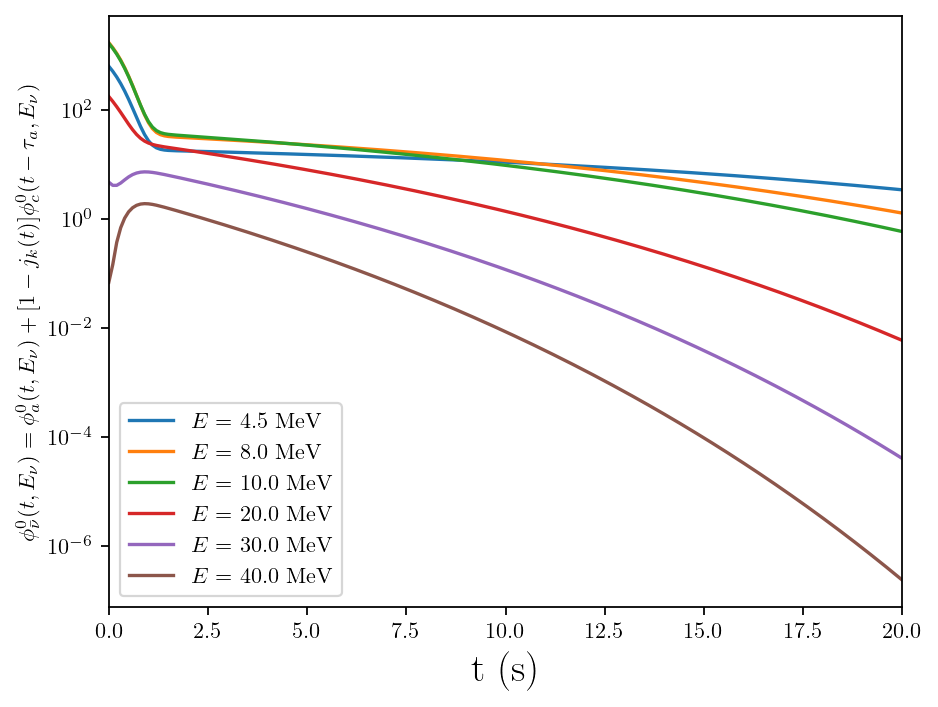

In [34]:
t = np.linspace(0,20,201)
Enu = [4.5,8,10,20,30,40]
Pee = 1
tau = 1.2
Tc0,tau_c,Rc = 4.81,4.1,12.3
Ta0,tau_a,Ma = 2,0.57,0.6

plt.figure(dpi=160)

for E_value in Enu:
    plt.plot(t, antinu_e_flux(t,E_value,Tc0,tau_c,Rc,tau,Ta0,tau_a,Ma,Pee,mass_ord="NH",acc="yes"), label='$E =$ %.1f MeV'%E_value)

plt.yscale('log')
plt.xlim(0,20)
plt.xlabel(r't (s)', fontsize=18)
plt.ylabel(r'$\phi_{\bar{\nu}}^0(t,E_\nu) = \phi_a^0(t,E_\nu) + [1 - j_k(t)] \phi_c^0(t-\tau_a,E_\nu)$')
plt.legend()
plt.show()

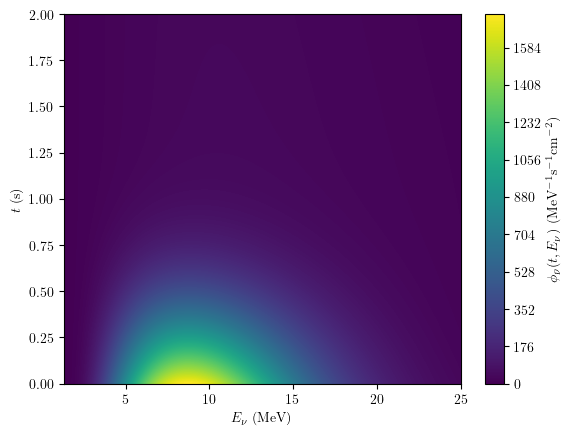

In [59]:

t = np.linspace(0,2,201)
Enu = np.linspace(1.293,25,201)

tt,EE = np.meshgrid(t,Enu)
Z = antinu_e_flux(tt,EE,Tc0,tau_c,Rc,tau,Ta0,tau_a,Ma,Pee,mass_ord="NH",acc="yes")

plt.contourf(EE,tt,Z,levels=1000)
bar = plt.colorbar()
bar.set_label(r'$\phi_{\bar{\nu}}(t,E_\nu)$ (MeV$^{-1}$s$^{-1}$cm$^{-2}$)')
plt.ylabel(r'$t$ (s)')
plt.xlabel(r'$E_\nu$ (MeV)')
plt.show()